## Check auxiliary variables to support global analysis

In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
import numpy.ma as ma
from scipy.interpolate import griddata
import copy
import netCDF4 as nc4
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from matplotlib import ticker, cm, colors


In [2]:
nlon = 180
nlat = 90
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89, 91, 2)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

### Check harvest rates within each GCAM agroecological regions

In [3]:
############################################################
## Open regional mask
############################################################
## Some constants
nlat = 46
nlon = 72
nyr = 216
beg_yr = 1800
rec_yr = 1700
nreg = 18
nhrv_type = 5

filename_in = 'AEZ_orig_4x5_c230404.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
ds = nc4.Dataset(filename_in)

reg_mask = ds['AEZ_MASK'][:]

ds.close()

## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_HIST_simyr1700-2015.biomass_harvest.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_area = fin_luinput.variables['AREA'][:]
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
lu_hrv_vh1_ori = fin_luinput.variables['HARVEST_VH1'][:]
lu_hrv_vh2_ori = fin_luinput.variables['HARVEST_VH2'][:]
lu_hrv_sh1_ori = fin_luinput.variables['HARVEST_SH1'][:]
lu_hrv_sh2_ori = fin_luinput.variables['HARVEST_SH2'][:]
lu_hrv_sh3_ori = fin_luinput.variables['HARVEST_SH3'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_harmonized_simyr1700-2015.biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_vh1_har = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_vh2_har = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_sh1_har = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_sh2_har = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_sh3_har = fin_luinput2.variables['HARVEST_SH3'][:]
fin_luinput2.close()


C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [4]:
# Validate total harvest rate in each region every year
lu_aez_hrv_ori = np.zeros([nhrv_type, nyr, nreg])
lu_aez_hrv_har = np.zeros([nhrv_type, nyr, nreg])
reg_mask_inuse = np.zeros([nlat, nlon])

for ireg in np.arange(0,nreg):
    # Obtain the regional mask
    reg_mask_inuse[reg_mask == (ireg+1)] = 1.0
    for iyr in np.arange(0,nyr):
        yr_id = iyr+(beg_yr - rec_yr)
        lu_aez_hrv_ori[0, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_vh1_ori[yr_id,:,:])
        lu_aez_hrv_ori[1, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_vh2_ori[yr_id,:,:])
        lu_aez_hrv_ori[2, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_sh1_ori[yr_id,:,:])
        lu_aez_hrv_ori[3, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_sh2_ori[yr_id,:,:])
        lu_aez_hrv_ori[4, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_sh3_ori[yr_id,:,:])
        lu_aez_hrv_har[0, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_vh1_har[yr_id,:,:])
        lu_aez_hrv_har[1, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_vh2_har[yr_id,:,:])
        lu_aez_hrv_har[2, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_sh1_har[yr_id,:,:])
        lu_aez_hrv_har[3, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_sh2_har[yr_id,:,:])
        lu_aez_hrv_har[4, iyr, ireg] = np.nansum(reg_mask_inuse*lu_hrv_sh3_har[yr_id,:,:])
    reg_mask_inuse = np.zeros([nlat, nlon])  
    

lu_aez_hrv_ori_tot = np.nansum(lu_aez_hrv_ori, 0)
lu_aez_hrv_har_tot = np.nansum(lu_aez_hrv_har, 0)

# biomass_fates_yr_tot = np.nansum(np.nansum(biomass_fates_yr, 2), 1)/1e12
# plt.plot(biomass_fates_yr_tot, 'b-', linewidth=3)
# plt.xlabel('Years since 1880')
# plt.ylabel('Total biomass (PgC)')
# plt.legend(['FATES'])
# plt.title('Validate spinup biomass')


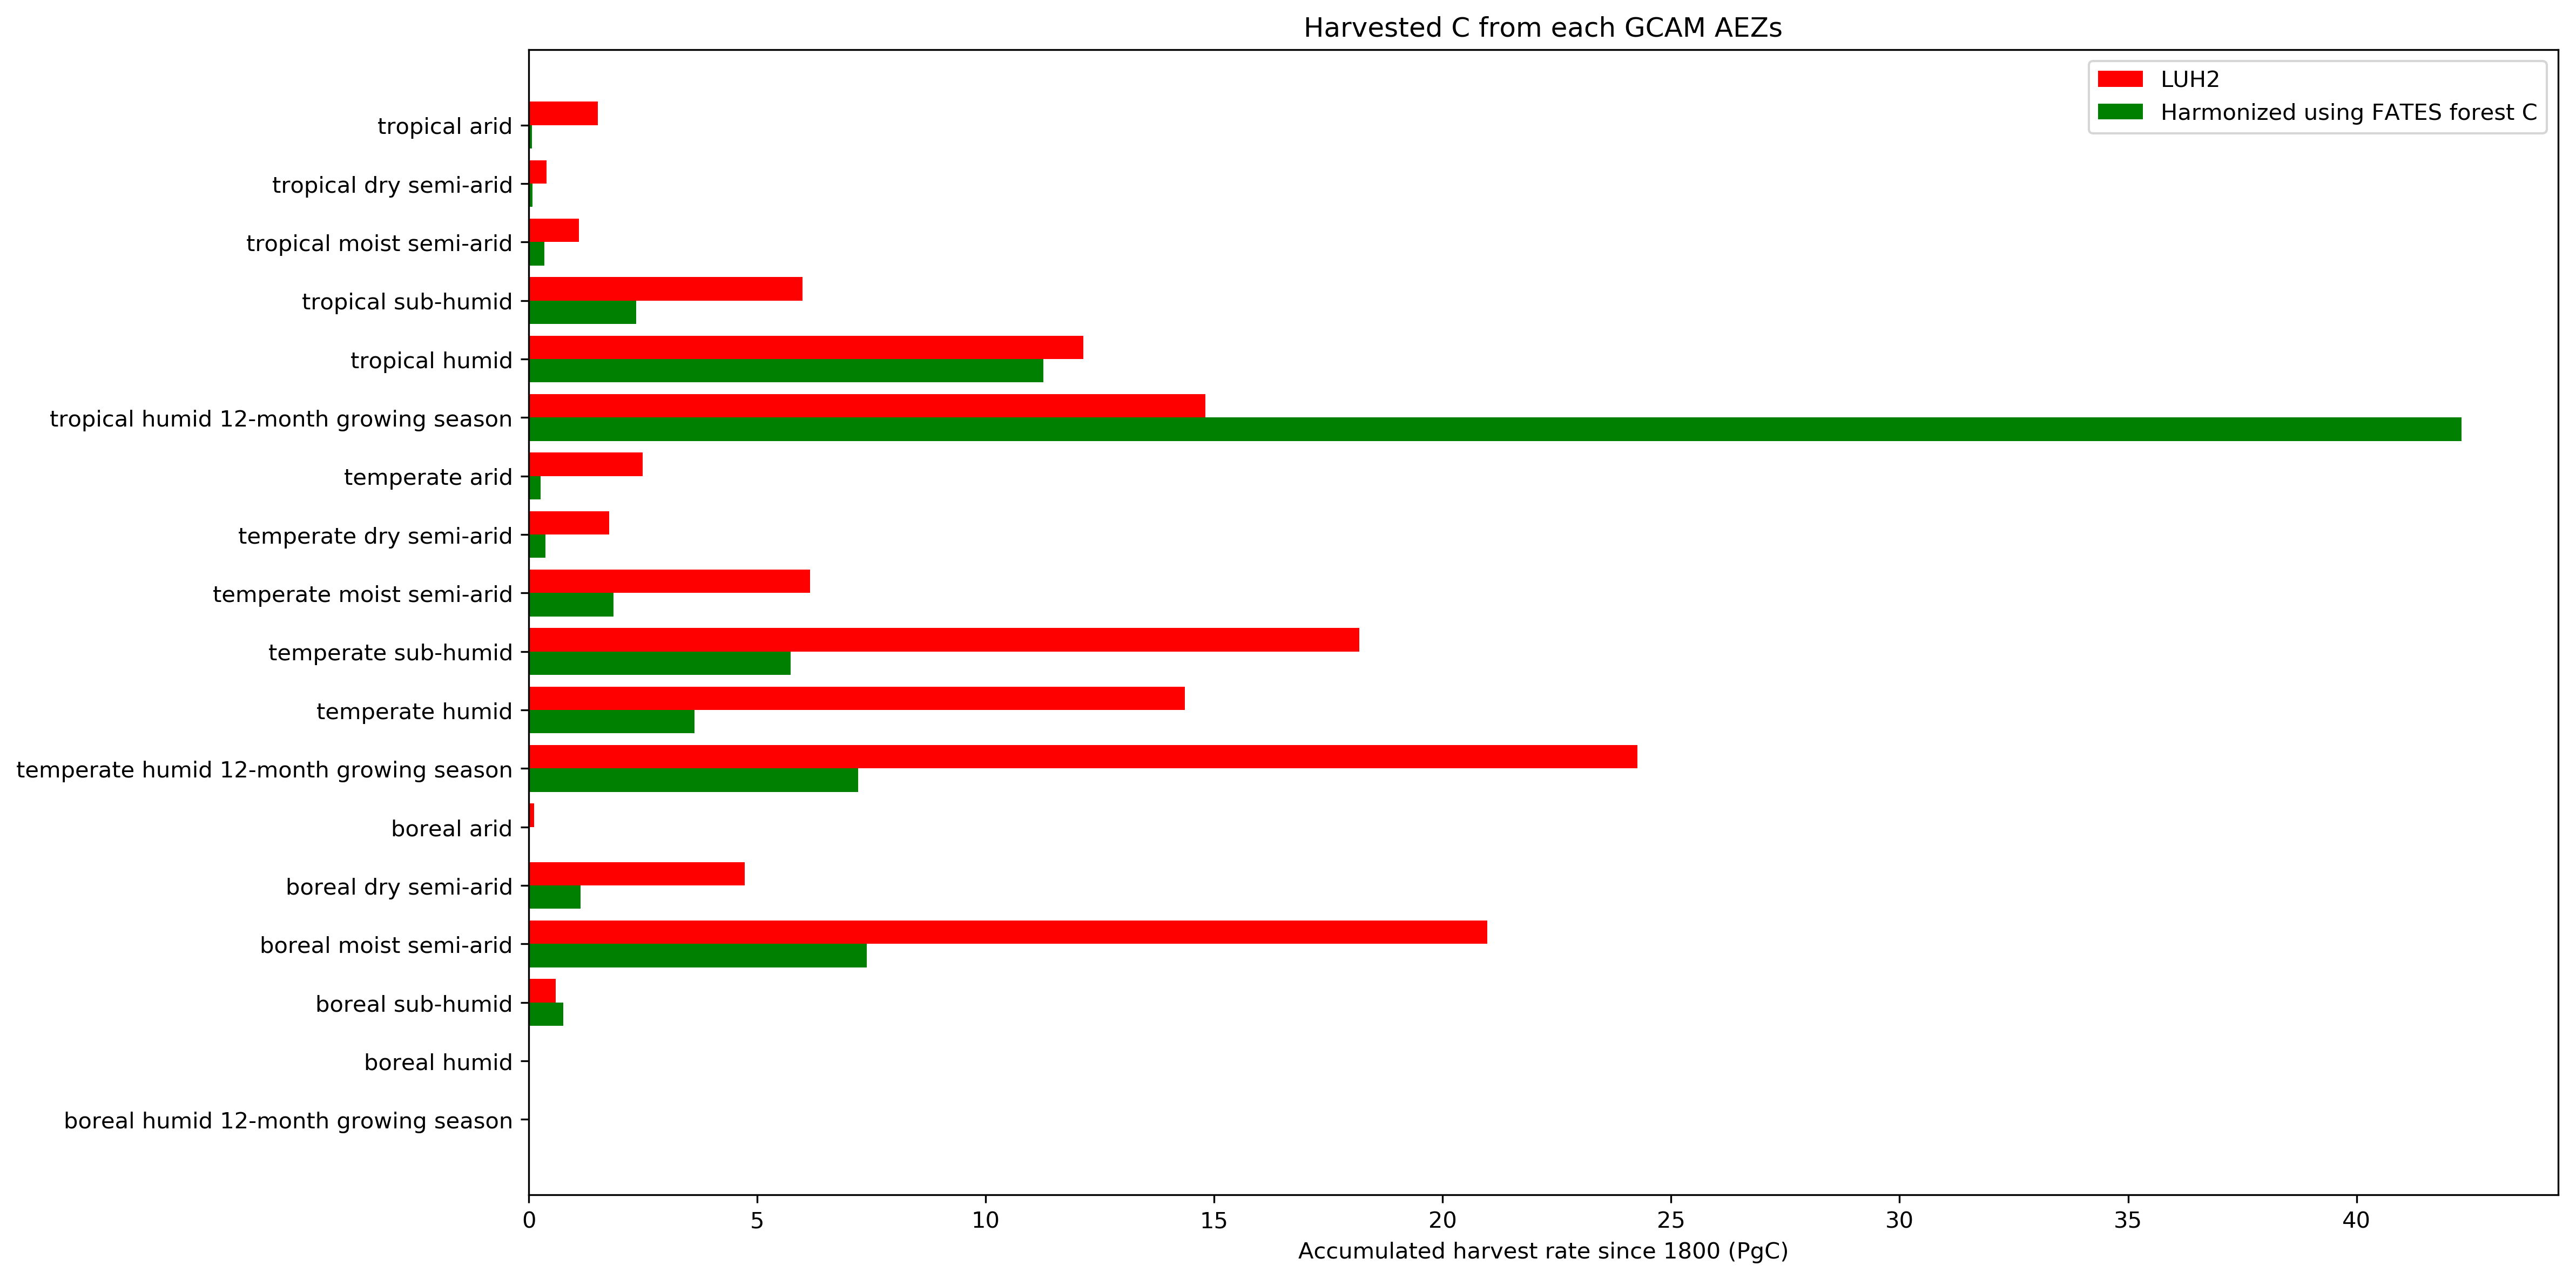

In [5]:
# Total harvest amount at 2015
fig, ax = plt.subplots(figsize=(16,8), dpi=300)

aez_name = ['tropical arid', 'tropical dry semi-arid', 'tropical moist semi-arid', 'tropical sub-humid', \
            'tropical humid', 'tropical humid 12-month growing season', 'temperate arid', 'temperate dry semi-arid', \
            'temperate moist semi-arid', 'temperate sub-humid', 'temperate humid', 'temperate humid 12-month growing season', \
            'boreal arid', 'boreal dry semi-arid', 'boreal moist semi-arid', 'boreal sub-humid', 'boreal humid', \
            'boreal humid 12-month growing season']
y_pos = np.arange(len(aez_name))

ax.barh(np.arange(0,nreg)-0.2, np.sum(lu_aez_hrv_ori_tot[:,:], 0)*1e-12, color ='r', height = 0.4)
ax.barh(np.arange(0,nreg)+0.2, np.sum(lu_aez_hrv_har_tot[:,:], 0)*1e-12, color ='g', height = 0.4)
# ax.set_xscale('log')
ax.set_yticks(y_pos)
ax.set_yticklabels(aez_name, fontsize=10)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accumulated harvest rate since 1800 (PgC)')
ax.set_title('Harvested C from each GCAM AEZs')
plt.legend(['LUH2', 'Harmonized using FATES forest C'])
fig.tight_layout()
plt.savefig('Evaluation_harmonization.png')


### Comparison between harmonized harv rates and LUH2 harv rate

In [6]:
# Obtain maps from three time periods: 1850s, 1920s and 2000s
luh2_pri = np.zeros([3, nlat, nlon])
har_pri = np.zeros([3, nlat, nlon])
luh2_sec = np.zeros([3, nlat, nlon])
har_sec = np.zeros([3, nlat, nlon])

idx_beg = ([(1850-rec_yr), (1920-rec_yr), (2000-rec_yr)])
idx_end = ([(1859-rec_yr), (1929-rec_yr), (2009-rec_yr)])

for i in np.arange(0,3):
    luh2_pri[i,:,:] = np.nanmean(lu_hrv_vh1_ori[idx_beg[i]:idx_end[i], :, :], 0) + np.nanmean(lu_hrv_vh2_ori[idx_beg[i]:idx_end[i], :, :], 0)
    har_pri[i,:,:] = np.nanmean(lu_hrv_vh1_har[idx_beg[i]:idx_end[i], :, :], 0) + np.nanmean(lu_hrv_vh2_har[idx_beg[i]:idx_end[i], :, :], 0)
    luh2_sec[i,:,:] = np.nanmean(lu_hrv_sh1_ori[idx_beg[i]:idx_end[i], :, :], 0) + np.nanmean(lu_hrv_sh2_ori[idx_beg[i]:idx_end[i], :, :], 0) + np.nanmean(lu_hrv_sh3_ori[idx_beg[i]:idx_end[i], :, :], 0)
    har_sec[i,:,:] = np.nanmean(lu_hrv_sh1_har[idx_beg[i]:idx_end[i], :, :], 0) + np.nanmean(lu_hrv_sh2_har[idx_beg[i]:idx_end[i], :, :], 0) + np.nanmean(lu_hrv_sh3_har[idx_beg[i]:idx_end[i], :, :], 0)

# Filter out negative and 0s
luh2_pri[luh2_pri<=0] = np.float('nan')
har_pri[har_pri<=0] = np.float('nan')
luh2_sec[luh2_sec<=0] = np.float('nan')
har_sec[har_sec<=0] = np.float('nan')


C:\Users\sshu3\Anaconda2\lib\site-packages\matplotlib\contour.py:1540: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\sshu3\Anaconda2\lib\site-packages\matplotlib\contour.py:1541: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: 'bboxes' cannot be empty

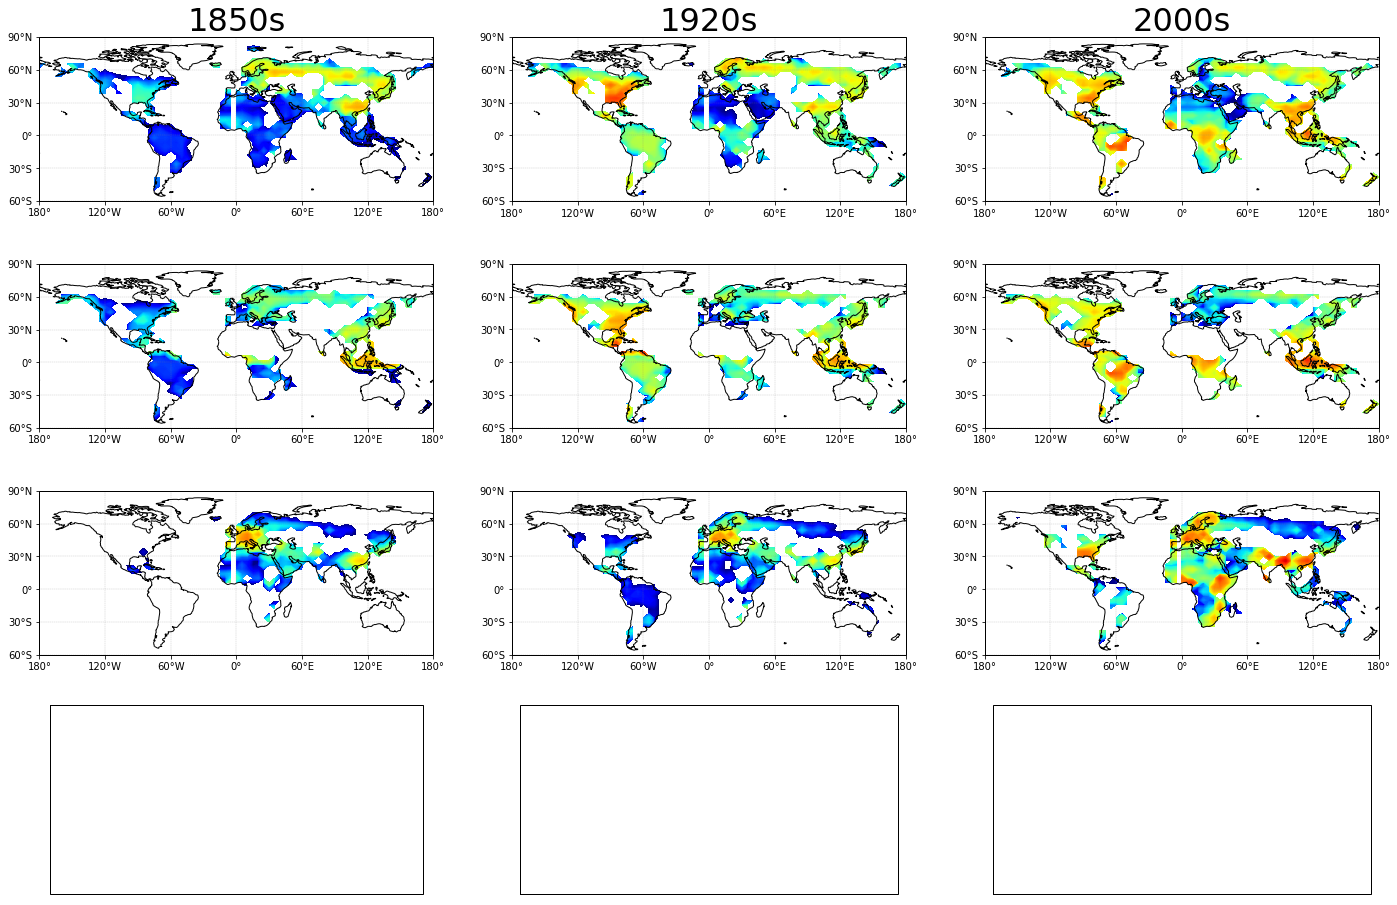

In [7]:
# Plot the figure (4 x 3)
# Comparison of harmonized prim/secd vs. LUH2 for 1850s, 1920s and 2000s

# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(24,16))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

col_titles = ['1850s', '1920s', '2000s']

# LUH2 Primary
for i in np.arange(0,3):
    # Contour plot
    cs=axs[i].contourf(lonnc, latnc, luh2_pri[i,:,:], 60, levels=np.logspace(6, 11, num=256, base=10), \
                   transform=ccrs.PlateCarree(), locator=ticker.LogLocator(), cmap=plt.cm.jet)

    # Title each subplot with the name of the model
    axs[i].set_title(col_titles[i], fontsize=32)

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
    gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
    # Define the xticks for longitude
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

# Har Primary
for i in np.arange(3,6):
    # Contour plot
    cs=axs[i].contourf(lonnc, latnc, har_pri[(i-3),:,:], 60, levels=np.logspace(6, 11, num=256, base=10), \
                   transform=ccrs.PlateCarree(), locator=ticker.LogLocator(), cmap=plt.cm.jet)

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
    gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
    # Define the xticks for longitude
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
# LUH2 Secondary
for i in np.arange(6,9):
    # Contour plot
    cs=axs[i].contourf(lonnc, latnc, luh2_sec[(i-6),:,:], 60, levels=np.logspace(6, 11, num=256, base=10), \
                   transform=ccrs.PlateCarree(), locator=ticker.LogLocator(), cmap=plt.cm.jet)

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
    gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
    # Define the xticks for longitude
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
# Har Secondary
for i in np.arange(9,12):
    # Contour plot
    cs=axs[i].contourf(lonnc, latnc, har_sec[(i-9),:,:], 60, levels=np.logspace(6, 11, num=256, base=10), \
                   transform=ccrs.PlateCarree(), locator=ticker.LogLocator(), cmap=plt.cm.jet)

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
    gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
    # Define the xticks for longitude
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.14, right=0.9,
                    wspace=0.1, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', spacing='proportional', 
                  extend = 'both', ticks =[1e6, 1e7, 1e8, 1e9, 1e10, 1e11])

cbar.ax.tick_params(labelsize=20)

# Add row titles at the left
fig.text(0.02, 0.8, 'LUH2 Primary', fontsize=20)
fig.text(0.02, 0.62, 'Re-harmonized', fontsize=20)
fig.text(0.02, 0.59, 'Primary', fontsize=20)
fig.text(0.02, 0.42, 'LUH2 Secondary', fontsize=20)
fig.text(0.02, 0.24, 'Re-harmonized', fontsize=20)
fig.text(0.02, 0.21, 'Secondary', fontsize=20)

# Unit:
fig.text(0.05, 0.1, 'Unit: kgC', fontsize=28)

# plt.tight_layout()
# plt.show()
plt.savefig('./harmonization_map.png',dpi=300)

### Check secondary forest area fraction

In [ ]:
# Open LUH2 states dataset
fpath = 'C:/Users/sshu3/anaconda_wkspace/states.nc'
nclu=nc4.Dataset(fpath)
secf_luh2 = nclu['secdf'][:]
secn_luh2 = nclu['secdn'][:]
lat_luh2 = nclu['lat'][:]
lon_luh2 = nclu['lon'][:]

nclu.close()

# Global grid area for 0.25 deg for LUH2 datasets
nlon = 1440
nlat = 720
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-89.875, 90.125, 0.25)
res = 0.25;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

### Add more works here

### Original LUH2 harvest rate data (takes long time)

In [ ]:
## Open LUH2 data for validation
# Open LUH2 transition original dataset
fpath = 'D:/LUH2/transitions.nc'
nclu=nc4.Dataset(fpath)
primf_bioh = nclu['primf_bioh'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh = nclu.variables['primn_bioh'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh = nclu['secmf_bioh'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh = nclu['secnf_bioh'][:]
# secmn_harv = nclu['secnf_harv'][:]

nclu.close()

nlon = 1440
nlat = 720
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89.875, 90.125, 0.25)
res = 0.25;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Mask
primf_bioh[primf_bioh>1e16] = np.float('nan')
primn_bioh[primn_bioh>1e16] = np.float('nan')
secmf_bioh[secmf_bioh>1e16] = np.float('nan')
secmn_bioh[secmn_bioh>1e16] = np.float('nan')

In [8]:
## Open LUH2 data for validation
# Open LUH2 transition original dataset
fpath = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc'
fpath_hi = 'landuse.timeseries_4x5_HIST_hi_simyr1850-2015.biomass_harvest.nc'
fpath_lo = 'landuse.timeseries_4x5_HIST_lo_simyr1850-2015.biomass_harvest.nc'
nclu=nc4.Dataset(fpath)
primf_bioh = nclu['HARVEST_VH1'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh = nclu['HARVEST_VH2'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh = nclu['HARVEST_SH1'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh = nclu['HARVEST_SH3'][:]
# secmn_harv = nclu['secnf_harv'][:]
nclu.close()

nclu=nc4.Dataset(fpath_lo)
primf_bioh_lo = nclu['HARVEST_VH1'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh_lo = nclu['HARVEST_VH2'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh_lo = nclu['HARVEST_SH1'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh_lo = nclu['HARVEST_SH3'][:]
# secmn_harv = nclu['secnf_harv'][:]
nclu.close()

nclu=nc4.Dataset(fpath_hi)
primf_bioh_hi = nclu['HARVEST_VH1'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh_hi = nclu['HARVEST_VH2'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh_hi = nclu['HARVEST_SH1'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh_hi = nclu['HARVEST_SH3'][:]
# secmn_harv = nclu['secnf_harv'][:]
nclu.close()

Text(0,0.5,'Total harvested C (PgC yr-1)')

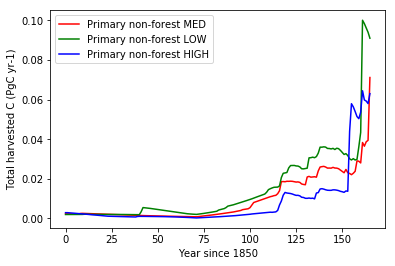

In [9]:
# Calculate the total primary forest harvest, non-forest harvest and secondary forest harvest, non-forest harvest
primf_bioh_tot = np.nansum(np.nansum(primf_bioh, 1), 1)/1e12
primn_bioh_tot = np.nansum(np.nansum(primn_bioh, 1), 1)/1e12
secmf_bioh_tot = np.nansum(np.nansum(secmf_bioh, 1), 1)/1e12
secmn_bioh_tot = np.nansum(np.nansum(secmn_bioh, 1), 1)/1e12

primf_bioh_lo_tot = np.nansum(np.nansum(primf_bioh_lo, 1), 1)/1e12
primn_bioh_lo_tot = np.nansum(np.nansum(primn_bioh_lo, 1), 1)/1e12
secmf_bioh_lo_tot = np.nansum(np.nansum(secmf_bioh_lo, 1), 1)/1e12
secmn_bioh_lo_tot = np.nansum(np.nansum(secmn_bioh_lo, 1), 1)/1e12

primf_bioh_hi_tot = np.nansum(np.nansum(primf_bioh_hi, 1), 1)/1e12
primn_bioh_hi_tot = np.nansum(np.nansum(primn_bioh_hi, 1), 1)/1e12
secmf_bioh_hi_tot = np.nansum(np.nansum(secmf_bioh_hi, 1), 1)/1e12
secmn_bioh_hi_tot = np.nansum(np.nansum(secmn_bioh_hi, 1), 1)/1e12

# Plots
plt.plot(primn_bioh_tot, 'r-')
plt.plot(primn_bioh_lo_tot, 'g-')
plt.plot(primn_bioh_hi_tot, 'b-')
# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Primary non-forest MED','Primary non-forest LOW', 'Primary non-forest HIGH'])

plt.xlabel('Year since 1850')
plt.ylabel('Total harvested C (PgC yr-1)')

In [ ]:
# Plots
plt.plot(secmn_bioh_tot, 'r-')
plt.plot(secmn_bioh_lo_tot, 'g-')
plt.plot(secmn_bioh_hi_tot, 'b-')
# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Secondary non-forest MED','Secondary non-forest LOW', 'Secondary non-forest HIGH'])

plt.xlabel('Year since 1850')
plt.ylabel('Total harvested C (PgC yr-1)')

In [ ]:
# Plots
plt.plot(primf_bioh_tot, 'r-')
plt.plot(primf_bioh_lo_tot, 'g-')
plt.plot(primf_bioh_hi_tot, 'b-')
# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Primary forest MED','Primary forest LOW', 'Primary forest HIGH'])

plt.xlabel('Year since 1850')
plt.ylabel('Total harvested C (PgC yr-1)')

In [ ]:
# Relative ratio
plt.plot(primn_bioh_tot[1000:1165]/primf_bioh_tot[1000:1165], 'r-')
plt.plot(secmn_bioh_tot[1000:1165]/secmf_bioh_tot[1000:1165], 'b-')
plt.legend(['Primary forest to non-forest ratio', 'Secondary forest to non-forest ratio'])
plt.xlabel('Year since 1850')
plt.ylabel('Ratio')

### Examine surface data (Dominant PFTs, number of PFTs from the surface data)

In [ ]:
############################################################
### Examine surface data
### Dominant PFTs, number of PFTs from the surface data
############################################################

## Some constants
nyr = 1

##  get and open the file
filename_in = 'surfdata_4x5_simyr1850_c211105.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
# lon = fin.variables['lsmlon'][:]
# lat = fin.variables['lsmlat'][:]

## read in variables
natveg = fin.variables['PCT_NATVEG'][:]
natpft = fin.variables['PCT_NAT_PFT'][:]

fin.close()

numpft = np.zeros((46,72))
dompft = np.zeros((46,72))
## Calculate numbers of PFTs
for i in np.arange(0,72):
    for j in np.arange(0,46):
        dominant_k = 1
        for k in np.arange(1,16):
            if(natpft[k,j,i] > 0.0):
                numpft[j,i] = numpft[j,i] + 1
            if(natpft[k,j,i]>natpft[dominant_k,j,i]):
                dominant_k = k
                dompft[j,i] = k
            


In [ ]:
### Plot to show number of PFTs and the dominant PFT
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,numpft[:,:],
              norm=colors.Normalize(vmin=0, vmax=16),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Number of PFTs', fontsize=24, color='White')

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,dompft[:,:],
              norm=colors.Normalize(vmin=0, vmax=16),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Dominant PFT', fontsize=24, color='White')

#plt.show()
plt.savefig('biogeog_map_global_4x5.png')

In [ ]:
## Check the biomass from nocomp simulation
## Some constants
nyr = 134

##  get and open the restart file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.2000s.spinup.nc'
filename_in = 'extracted_nocomp_spinup_1850_1983.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)

## read in variables
biomass = fin.variables['FATES_VEGC'][:]
area_age = fin.variables['FATES_PATCHAREA_AP'][:]
landfrac = fin.variables['landfrac'][:]
# hrv_c = fin.variables['HARVEST_CARBON_FLUX'][:]
# hrv_debt = fin.variables['HARVEST_DEBT'][:]
# hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# sec_frac = fin.variables['SECONDARY_FOREST_FRACTION'][:]

fin.close()

## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_area = fin_luinput.variables['AREA'][:]
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
lu_hrv_frac_vh1 = fin_luinput.variables['HARVEST_VH1'][:]
lu_hrv_frac_vh2 = fin_luinput.variables['HARVEST_VH2'][:]
lu_hrv_frac_sh1 = fin_luinput.variables['HARVEST_SH1'][:]
lu_hrv_frac_sh2 = fin_luinput.variables['HARVEST_SH2'][:]
lu_hrv_frac_sh3 = fin_luinput.variables['HARVEST_SH3'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
nat_area_frac = np.nansum(area_age, 1)
nat_area_frac[nat_area_frac>100] = 0.0
biomass_den = biomass
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lon_4x5 = lonnc
lu_hrv_frac = lu_hrv_frac_vh1+lu_hrv_frac_vh2#+lu_hrv_frac_sh1+lu_hrv_frac_sh2+lu_hrv_frac_sh3
lu_hrv_c = lu_hrv_c_vh1+lu_hrv_c_vh2


In [ ]:
# Validate global total biomass C in Spinup
biomass_fates_day = copy.deepcopy(biomass_den)
biomass_fates_day[biomass_fates_day>100] = np.float('nan')
biomass_fates_yr = np.zeros([134, 46, 72])
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_fates_yr[iyr,:,:] = biomass_fates_day[id_end,:,:]*landfrac*area_4x5*nat_area_frac[id_end,:,:]*1e6
#     hrv_area_lu_yr[iyr,:,:] = lu_hrv_frac[151+iyr,:,:]*area_4x5*nat_area_frac[0,:,:]/1e6

# Mask ocean
biomass_fates_yr[biomass_fates_yr<0] = np.float('nan')

biomass_fates_yr_tot = np.nansum(np.nansum(biomass_fates_yr, 2), 1)/1e12
plt.plot(biomass_fates_yr_tot, 'b-', linewidth=3)
plt.xlabel('Years since 1850')
plt.ylabel('Total biomass (PgC)')
plt.legend(['FATES'])
plt.title('Validate spinup biomass')

In [ ]:
# Biomass map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[1607,:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')

# cs1 = map.pcolormesh(x,y,hrv_debt_sec[100,:,:],
#               norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,
# cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')

# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Biomass (in kgC m-2)', fontsize=24)

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,biomass_den[1601,:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Biomass (in kgC m-2)', fontsize=24)

plt.show()
#plt.savefig('FATES_biomass_hrvdebt_global_map.png')

In [ ]:
############################################################
### Open and print LUH2 harvest rate data
############################################################

## Some constants
nyr = 1166
start_year = 850
end_year = 2015

##  get and open the restart file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.2000s.spinup.nc'
filename_in = 'D:/LUH2/transitions.nc'

nclu=nc4.Dataset(filename_in)
primf_bioh = nclu['primf_bioh'][:]
# primf_harv = nclu['primf_harv'][:]
primn_bioh = nclu.variables['primn_bioh'][:]
# primn_harv = nclu['primn_harv'][:]
secmf_bioh = nclu['secmf_bioh'][:]
# secmf_harv = nclu['secmf_harv'][:]
secmn_bioh = nclu['secnf_bioh'][:]
# secmn_harv = nclu['secnf_harv'][:]
secyf_bioh = nclu['secyf_bioh'][:]
# secyf_harv = nclu['secyf_harv'][:]

nclu.close()

nlon = 1440
nlat = 720
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89.875, 90.125, 0.25)
res = 0.25;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Mask
primf_bioh[primf_bioh>1e16] = np.float('nan')
primn_bioh[primn_bioh>1e16] = np.float('nan')
secmf_bioh[secmf_bioh>1e16] = np.float('nan')
secmn_bioh[secmn_bioh>1e16] = np.float('nan')
secyf_bioh[secyf_bioh>1e16] = np.float('nan')



In [ ]:
# Calculate the total primary forest harvest, non-forest harvest and secondary forest harvest, non-forest harvest
primf_bioh_tot = np.nansum(np.nansum(primf_bioh, 1), 1)/1e12
primn_bioh_tot = np.nansum(np.nansum(primn_bioh, 1), 1)/1e12
secmf_bioh_tot = np.nansum(np.nansum(secmf_bioh, 1), 1)/1e12
secmn_bioh_tot = np.nansum(np.nansum(secmn_bioh, 1), 1)/1e12
secyf_bioh_tot = np.nansum(np.nansum(secyf_bioh, 1), 1)/1e12

# primf_bioh_lo_tot = np.nansum(np.nansum(primf_bioh_lo, 1), 1)/1e12
# primn_bioh_lo_tot = np.nansum(np.nansum(primn_bioh_lo, 1), 1)/1e12
# secmf_bioh_lo_tot = np.nansum(np.nansum(secmf_bioh_lo, 1), 1)/1e12
# secmn_bioh_lo_tot = np.nansum(np.nansum(secmn_bioh_lo, 1), 1)/1e12
# secyf_bioh_lo_tot = np.nansum(np.nansum(secyf_bioh_lo, 1), 1)/1e12

# primf_bioh_hi_tot = np.nansum(np.nansum(primf_bioh_hi, 1), 1)/1e12
# primn_bioh_hi_tot = np.nansum(np.nansum(primn_bioh_hi, 1), 1)/1e12
# secmf_bioh_hi_tot = np.nansum(np.nansum(secmf_bioh_hi, 1), 1)/1e12
# secmn_bioh_hi_tot = np.nansum(np.nansum(secmn_bioh_hi, 1), 1)/1e12
# secyf_bioh_hi_tot = np.nansum(np.nansum(secyf_bioh_hi, 1), 1)/1e12

# Accumulated harvest rate before 1700
primf_bioh_tot_bef_1700 = np.nansum(primf_bioh_tot[1:850])

# Plots
plt.plot(primf_bioh_tot, 'r-')
plt.plot(primn_bioh_tot, 'g-')
plt.plot(secmf_bioh_tot, 'b-')
plt.plot(secyf_bioh_tot, 'c-')
plt.plot(secmn_bioh_tot, 'k-')

# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Primary forest','Primary non-forest', 'Secondary mature forest', 'Secondary young forest', 'Secondary non-forest'])

plt.xlabel('Year since 850')
plt.ylabel('Total harvested C (PgC yr-1)')